# Imputation Analysis

In [175]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_results(y_true, y_pred, verbose=0):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_func(y_true, y_pred)
    f2 = f2_func(y_true, y_pred)
    if verbose:
        results = [
            ("accuracy", accuracy), 
            ("precision", precision),
            ("recall", recall),
            ("f1", f1),
            ("f2", f2),
        ]
        print("\nCLASSIFICATION METRICS:\n")
        for (metric, score) in results:
            print(f"{metric} = {score:.2f}")
        print("\n")
    return [accuracy, precision, recall, f1, f2]

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

Get the data

In [170]:
impute_dir = os.path.join(base_dir, "data/altered/imputed")
mf_dir = os.path.join(impute_dir, "multiple/missforest")
impute_paths = [(name[5:-4], os.path.join(impute_dir, name)) for name in os.listdir(impute_dir) if name[-4:] == ".csv"]
mf_paths = [(name[:-4], os.path.join(mf_dir, name)) for name in os.listdir(mf_dir)]
impute_paths += mf_paths
all_imputations = [(name, pd.read_csv(path, index_col=0)) for (name, path) in impute_paths]

Sort imputed dataframes

In [176]:
imputations = []
imputations_to_use = [
    "meanmode_impute", 
    "hotdeck_impute", 
    "linlog_reg_impute", 
    "stochastic_linlog_reg_impute", 
    "randomforest_impute", 
    "xgboost_impute",
    "missforest_imputation_1"
]

for (name, df) in all_imputations:
    if name in imputations_to_use:
        if name == "missforest_imputation_1":
            name = "iterative_randomforest"
        else:
            name = name[:-7]
        imputations.append((name, df))

## Classification of depression diagnosis

Create a test set from the original data. As we are aiming to classify `has_dep_diag`, we remove `prim_diag` and `secd_diag` as zero in these features indicates they have no depression diagnosis and non-zero indicates they do, i.e. `has_dep_diag` is a binary indication of there being a non-zero in `prim_diag` or `secd_diag`, which is of no interest for our classification task.

In [177]:
orig_path = os.path.join(base_dir, "data/altered/maps_feature_mapping.csv")

orig_df = pd.read_csv(orig_path, index_col="X")
orig_X = orig_df.dropna(subset=["has_dep_diag"], inplace=False).drop(["has_dep_diag", "prim_diag", "secd_diag"], axis=1)
orig_y = orig_df["has_dep_diag"].dropna(inplace=False)

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, test_size=0.2, random_state=42)

In [178]:
orig_X_train

,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
11927,0.0,0.0,30.0,58.778725,172.929421,89.0,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3013,0.0,0.0,28.0,77.551143,176.746393,108.0,NaN,1.0,1.0,1.0,...,4.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
7105,0.0,5.0,33.0,59.698695,167.282533,108.0,NaN,1.0,0.0,1.0,...,0.0,NaN,NaN,1.0,1.0,2.0,0.0,2.0,0.0,0.0
4418,0.0,2.0,25.0,NaN,NaN,NaN,NaN,1.0,0.0,3.0,...,0.0,NaN,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0
11776,0.0,8.0,24.0,59.441480,169.877891,98.0,NaN,NaN,0.0,1.0,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13468,0.0,4.0,29.0,87.882633,174.486229,111.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,1.0,2.0,2.0,0.0,0.0
1423,0.0,5.0,31.0,59.546015,170.829523,136.0,NaN,NaN,1.0,0.0,...,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,0.0
9290,0.0,11.0,23.0,46.759026,159.871163,63.0,NaN,NaN,1.0,1.0,...,1.0,NaN,NaN,0.0,NaN,2.0,2.0,2.0,1.0,1.0


`Note: as this dataset has no imputations we cannot train or test on rows with missing data in has_dep_diag. This will likely influence the results as missing data is MNAR, as discussed in our missing data analysis.`

Train base XGBoost classifier without imputations.

In [180]:
clf_results = pd.DataFrame(columns=["Imputation Method", "Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"])

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss"
)
xgb.fit(orig_X_train, orig_y_train)

preds = xgb.predict(orig_X_test)
results = classification_results(orig_y_test, preds, verbose=1)

clf_results.loc[len(clf_results)] = ["No Imputation"] + results

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

CLASSIFICATION METRICS:

accuracy = 0.95
precision = 0.72
recall = 0.60
f1 = 0.66
f2 = 0.62




Feature importance:

In [181]:
imp_df = pd.DataFrame(zip(orig_X_train.columns, xgb.feature_importances_), columns=["feature", "importance"])
imp_df.sort_values("importance", ascending=False)

,feature,importance
69,dep_score,0.188190
68,dep_thoughts,0.041033
70,comp_house,0.036036
17,play_wend,0.032052
30,draw_week,0.023001
...,...,...
7,comp_int_bed_16,0.001043
45,phys_cruel,0.001010
31,play_week,0.000529
6,comp_noint_bed_16,0.000000


## Classification of imputations

We will use the same test set as above, so we are always testing on real data (for the target labels), but we shall use the imputed dataset for training. This should give us a good understanding of how well imputation methods have done.

In [182]:
test_idxs = orig_y_test.index.tolist()
train_idxs = [idx for idx in orig_df.index if idx not in test_idxs]

Train XGBoost classifier on each imputed dataset.

In [183]:
for (name, df) in imputations:

    X = df.drop(["has_dep_diag", "prim_diag", "secd_diag"], axis=1)
    y = df["has_dep_diag"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # # fix idxs for randomforest
    # if name == "iterative_randomforest":
    #     rf_idxs = [x - 1 for x in train_idxs]
    #     X_train, y_train = X.loc[rf_idxs], y.loc[rf_idxs]
    # else:
    #     X_train, y_train = X.loc[train_idxs], y.loc[train_idxs]

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
    )

    xgb.fit(X_train, y_train)
    preds = xgb.predict(orig_X_test)
    results = classification_results(orig_y_test, preds)

    clf_results.loc[len(clf_results)] = [name] + results

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Look at classification results.

In [184]:
clf_results

,Imputation Method,Accuracy,Precision,Recall,F1-Score,F2-Score
0,No Imputation,0.949059,0.721311,0.602740,0.656716,0.623229
1,xgboost,0.991141,0.971014,0.917808,0.943662,0.927978
2,meanmode,0.975637,0.981132,0.712329,0.825397,0.753623
3,hotdeck,0.942414,0.636364,0.671233,0.653333,0.663957
4,stochastic_linlog_reg,0.955703,0.770492,0.643836,0.701493,0.665722
5,linlog_reg,0.974529,0.980769,0.698630,0.816000,0.741279
6,randomforest,0.968992,0.941176,0.657534,0.774194,0.699708
7,iterative_randomforest,0.972315,0.944444,0.698630,0.803150,0.736994


## Classification with reduced feature set

Results are likely too accurate due to many other medical features such as `dep_score` and `dep_band` being so closely related.

Let's remove any depression and anxiety related features.

In [185]:
target_feature = ["has_dep_diag"]

non_med_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10", 
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

screen_time_features = [
    "comp_bed_9", "comp_noint_bed_16", 
    "comp_int_bed_16", "comp_wend", "tv_wend",
    "comp_week", "tv_week", "tv_bed_9", 
    "comp_house", "tv_bed_16", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor",
]

# reduced_df = orig_df[non_med_features + target_feature].copy()

# # remove rows with missing values in target feature
# notnull_idxs = reduced_df["has_dep_diag"].notnull()
# reduced_df = reduced_df[notnull_idxs]

# reduced_X = reduced_df.drop(["has_dep_diag"], axis=1)
# reduced_y = reduced_df["has_dep_diag"]

# reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, reduced_y, stratify=reduced_y, random_state=42)
# X_test, y_test = reduced_X_test, reduced_y_test

# # get test and train indexs
# test_idxs = y_test.index.tolist()
# train_idxs = reduced_y_train.index.tolist()

# # fix indexes to start at 0 for np array
# np_test_idxs = [x - 1 for x in test_idxs]
# np_train_idxs = [x - 1 for x in train_idxs]

# reduced_X = orig_df[non_med_features]
# reduced_y = orig_df[target_feature]

# reduced_X_train = reduced_X.loc[train_idxs]
# reduced_y_train = reduced_y.loc[train_idxs]

# reduced_X_test = reduced_X.loc[test_idxs]
# reduced_y_test = reduced_y.loc[test_idxs]

reduced_X = orig_df.dropna(subset=["has_dep_diag"], inplace=False)[non_med_features]
reduced_y = orig_df["has_dep_diag"].dropna(inplace=False)

reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, reduced_y, test_size=0.2, random_state=42)

Get the ratio of negatives to positive classes.

In [166]:
dep_counts = reduced_y_train.value_counts()
sample_ratio = dep_counts[0] / dep_counts[1]

print(f"minority:majority = {dep_counts[1]}:{dep_counts[0]} (1:{sample_ratio:.0f})")

minority:majority = 316:3294 (1:10)


Train xgb on non-imputed data as base results.

In [194]:
reduced_clf_results = pd.DataFrame(columns=["Imputation Method", "Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"])

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    # scale_pos_weight=sample_ratio,
)

xgb.fit(reduced_X_train, reduced_y_train)

preds = xgb.predict(reduced_X_test)
results = classification_results(reduced_y_test, preds)

reduced_clf_results.loc[len(reduced_clf_results)] = ["No Imputation"] + results

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [195]:
reduced_clf_results

,Imputation Method,Accuracy,Precision,Recall,F1-Score,F2-Score
0,No Imputation,0.920266,0.666667,0.027397,0.052632,0.033898


Now lets compare with the imputed datasets.

In [196]:
for (name, df) in imputations:

    X = df[non_med_features]
    y = df[target_feature]

    # # fix for rf imputation having indexes starting at 0
    # if name == "iterative_randomforest":
    #     X_train, y_train = X.loc[np_train_idxs], y.loc[np_train_idxs]
    # else:
    #     X_train, y_train = X.loc[train_idxs], y.loc[train_idxs]

    # xgb = XGBClassifier(
    #     objective="binary:logistic",
    #     eval_metric="logloss",
    #     scale_pos_weight=sample_ratio,
    # )
    # xgb.fit(X_train, y_train)

    # preds = xgb.predict(X_test)

    # results = classification_results(y_test, preds)

    # # fix idxs for randomforest
    # if name == "iterative_randomforest":
    #     rf_idxs = [x - 1 for x in train_idxs]
    #     X_train, y_train = X.loc[rf_idxs], y.loc[rf_idxs]
    # else:
    #     X_train, y_train = X.loc[train_idxs], y.loc[train_idxs]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
    )

    xgb.fit(X,  y)
    preds = xgb.predict(reduced_X_test)
    results = classification_results(reduced_y_test, preds)

    reduced_clf_results.loc[len(reduced_clf_results)] = [name] + results

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Show results

In [197]:
reduced_clf_results

,Imputation Method,Accuracy,Precision,Recall,F1-Score,F2-Score
0,No Imputation,0.920266,0.666667,0.027397,0.052632,0.033898
1,xgboost,0.947951,0.647727,0.780822,0.708075,0.750000
2,meanmode,0.953488,0.878049,0.493151,0.631579,0.540541
3,hotdeck,0.887043,0.320988,0.356164,0.337662,0.348525
4,stochastic_linlog_reg,0.888151,0.315789,0.328767,0.322148,0.326087
5,linlog_reg,0.962348,1.000000,0.534247,0.696429,0.589124
6,randomforest,0.953488,0.942857,0.452055,0.611111,0.504587
7,iterative_randomforest,0.954596,0.970588,0.452055,0.616822,0.506135


Plot results

<AxesSubplot:title={'center':'Classification Metrics of Depression Diagnosis Using Imputed Datasets'}, ylabel='Imputation Method'>

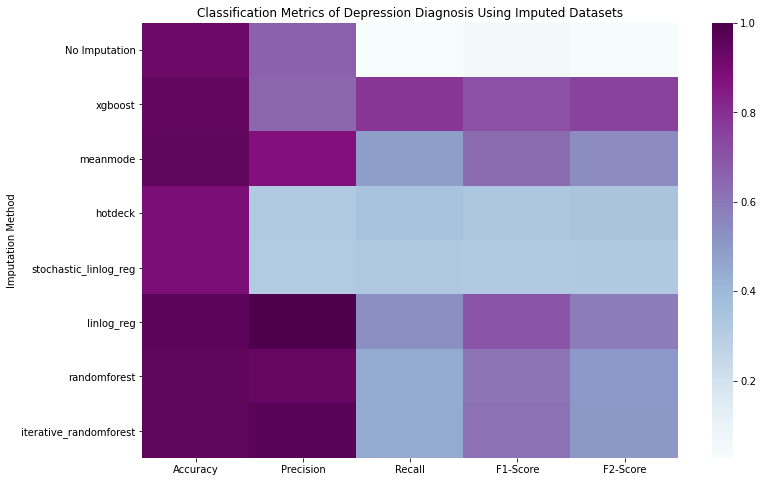

In [202]:
plt.figure(figsize=(12,8))
plt.title("Classification Metrics of Depression Diagnosis Using Imputed Datasets")
sns.heatmap(reduced_clf_results.set_index("Imputation Method"), cmap="BuPu")

Note that results without imputation are poor. This is likely due to some of the logical substitutions made during imputation for features which only had one value. Without imputation these features held no real information. Poor results could also be a result of training on a reduced training set, due to missing target labels in the non-imputed dataset. These missing labels are imputed otherwise and so the training set increases from around ~4k samples to ~13k. Not only does the absolute number of samples grow, but the type of data. As data is MNAR, whole classes can sometimes be left from the dataset due to missing values representing categories themselves. These issues were resolved in imputation and it shows in the classification results above.

Hot-deck and stochastic regression methods add a degree of randomness to their imputation; with hot-deck simply imputiing a random class and stochastic regression adding randomness to the predictions of linear / logistic regression imputation. Above we can see they have not performed well. This is likely due to the method of randomness being sub-optimal. The randomness in these methods could be improved by sampling from a normal distribution centred over the mean of the feature with the same variance as the feature. This would likely see better results although these methods are unlikely to outperform others. Hot-deck imputation does not account for inter-feature relationships and regression assumes linear relationships between features. It seems model based imputation is best for our data although interestingly mean and mode imputation did not perform that poorly, likely due to the prior logical substitutions made beforehand.

Of the imputation methods XGBoost modelling performed the best. As described in imputation, XGBoost can work with missing values present in the dataset. This is beneficial over other methods such as random forest imputation as we do not need to fill missing values with simple imputation methods in order to make predictions. This in turn leaves the distribution of the data as it was with the original, not skewing it by over-representing mean or mode values with other methods.

For these reasons we shall use the XGBoost imputed dataset for our further analysis.

In [221]:
train_path = os.path.join(base_dir, "data/classification/train.csv")
test_path = os.path.join(base_dir, "data/classification/test.csv")

xgb_df = imputations[0][1]
X_xgb = xgb_df.drop(target_feature, axis=1)
y_xgb = xgb_df[target_feature]
X_orig = orig_df.dropna(subset=target_feature).drop(target_feature, axis=1)
y_orig = orig_df.dropna(subset=target_feature)[target_feature]

X_train_xgb, _, y_train_xgb, _ = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
_, X_test_xgb, _, y_test_xgb = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)

train_df, test_df = X_train_xgb.copy(), X_test_xgb.copy()
train_df["has_dep_diag"], test_df["has_dep_diag"] = y_train_xgb, y_test_xgb
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)